In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mnist import MNIST
import random

In [2]:
mndata = MNIST("dat")
train = np.array(mndata.load_training()).T
test = np.array(mndata.load_testing()).T

pd.DataFrame(train)

,0,1
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9
...,...,...
59995,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",8
59996,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3
59997,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5
59998,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6


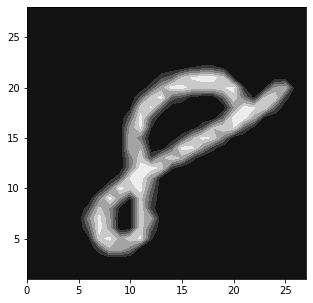

In [3]:
def displayimg(index : int):
    """
    display function for image data
    """
    sampleimg = np.array(train[index, 0]).reshape(28,28)
    x = np.arange(28)
    y = np.arange(28, 0, -1)

    xx, yy = np.meshgrid(x, y)

    plt.figure(figsize = (5,5))
    plt.contourf(xx, yy, sampleimg, cmap = "gray")
    plt.show()
    
displayimg(59999)

In [10]:
class NeuralNetwork(object):
    def __init__(self, sizes):
        """
        constructor for a neural network.
        from https://github.com/mnielsen/neural-networks-and-deep-learning/
             blob/master/src/network.py
        """
        self.nLayers = len(sizes)
        self.sizes = sizes
        
        self.biases = [np.random.randn(y, 1) \
                       for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) \
                        for x, y in zip(sizes[:-1], sizes[1:])]
        
    def feedFwd(self, arr):
        """
        forward feeding, one iteration
        """
        for b, w in zip(self.biases, self.weights):
            arr = relu(np.dot(w, arr) + b)
        
        return arr
    
    def stochasticGradDesc(self, trainDat, nEpoch, sSSize, rate, testDat = None):
        
        if testDat: nTest = len(testDat)
        
        nTrain = len(trainDat)
        
        for i in range(nEpoch):
            random.shuffle(trainDat)
            
            subSets = [train[k : k + sSSize] for k in range(0, nTrain, sSSize)]
            
            for subSet in subSets:
                self.updSubSet(subSet, rate)
                
            if testDat:
                print("Epoch {0}: {1} / {2}".format(
                    i, self.evaluate(testDat), nTest))
                
            else:
                print("Epoch {0} complete".format(i))
        
        
        
    
    def updSubSet(self, subSet, rate):
        
        # initialise weight gradients and bias gradients
        
        nabB = [np.zeros(b.shape) for b in self.biases]
        nabW = [np.zeros(w.shape) for w in self.weights]
        
        sSSize = len(subSet)
        
        # update
        
        for x, y in subSet:
            delNabB, delNabW = self.propBwd(x, y)
            
            nabB = [nB + dnB for nB, dnB in zip(nabB, delNabB)]
            nabW = [nW + dnW for nW, dnW in zip(nabW, delNabW)]
            
            
        self.weights = [Wi - (rate / sSSize) * nabWi \
                        for Wi, nabWi in zip(self.weights, nabW)]
        
        self.biases = [Bi - (rate / sSSize) * nabBi  \
                       for Bi, nabBi in zip(self.biases, nabB)]
        
        
    def evaluate(self, testDat):
        results = [np.argmax(self.feedFwd(x), y) for x, y in testDat]
        
        return sum(int(x == y) for x, y in results)
        
        
    def difCost(self, outAct, y):
        return outAct - y
        
    def propBwd(self, x, y):
        
        # initialise weight gradients and bias gradients
        
        nabB = [np.zeros(b.shape) for b in self.biases]
        nabW = [np.zeros(w.shape) for w in self.weights]
        
        # forward propagation
        
        act = x
        acts = np.array([x])
        
        zVecs = np.array([])
        
        # feedFwd is not called to store the z and a values
        
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, act) + b
            np.append(zVecs, z)
            
            act = self.reLU(z)
            np.append(acts, act, axis = 0)
            
        # bwd
        
        delta = self.difCost(acts[-1], y) * self.difReLU(zVecs[-1])
        
        nabB[-1] = delta
        nabW[-1] = np.dot(delta, acts[-2].T)
        
        # for the rest of the network
        
        for l in range(2, self.nLayers):
            z = zVecs[-l]
            dReLU = self.difReLU(z)
            
            delta = np.dot(delta, acts[-l-1].T)
            
        return nabB, nabW
    
    
    ####### activation functions #######
    
    
    def softmax(self, z):
        """Compute softmax values for each sets of scores in z."""
        e_z = np.exp(z - np.max(z))
        return e_z / e_z.sum()
            
    def reLU(self, z):
        """ReLU function"""
        return np.maximum(0, z)
    
    def difReLU(self, z):
        return z > 0
    

In [11]:
neuNet = NeuralNetwork([784, 16, 16, 10])

neuNet.stochasticGradDesc(train, 500, 10, 0.5)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 784 and the array at index 1 has size 16